# 시나리오#1

### 웹 스크래핑, 크롤러
- 분단위 평균 기록횟수를 훌쩍 넘어가는 특정 시간대를 추출하여 리스팅
- 추출된 특정 시간대에서 사용된 UA 중 특수한 UA가 있는지 추출
- 추출된 특정 시간대에서 일반적인 접속량을 훌쩍 넘기는 Host 추출하여 리스팅
- 추출된 10개 Host의 패턴 분석 (Referer, Path, Bytes, 머무는 시간 등)
- 발견된 패턴대로 다른 Host에 대입하여 웹 스크래핑 입증

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='AppleGothic') # 한글폰트 불러오기
plt.rcParams['axes.unicode_minus'] = False # - 안깨지게 하기

In [3]:
df = pd.read_csv('../dataset/track1.csv') # 데이터 프레임 초기화
df.Timestamp = pd.to_datetime(df.Timestamp) 
df = df[df['Status'].astype(str).str.isnumeric()] # 이상치 제거
# df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M') # 시계열 데이터를 1분 단위로 설정
df.head()

,Timestamp,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
0,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
1,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
2,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0
3,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0
4,2020-08-24 10:00:19,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0


In [4]:
time_grp = df.groupby(['Timestamp'])
time_grp.count()

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
Timestamp,,,,,,,,,
2020-08-24 10:00,9,9,9,9,9,9,9,9,9
2020-08-24 10:01,11,11,11,11,11,11,11,11,11
2020-08-24 10:02,28,28,28,28,28,28,28,28,28
2020-08-24 10:03,38,38,38,38,38,38,38,38,38
2020-08-24 10:04,31,31,31,31,31,31,31,31,31
...,...,...,...,...,...,...,...,...,...
2020-08-28 19:42,48,48,48,48,48,48,48,48,48
2020-08-28 19:43,49,49,49,49,49,48,49,49,49
2020-08-28 19:44,54,54,54,54,54,54,54,54,54


# 분당 개별 유니크 호스트 수와 분당 가장 기록을 많이 남긴 호스트

In [5]:
funcHostUnique = lambda x: len(x['Host'].unique())
funcHostUniqueFirstValue = lambda x: x['Host'].value_counts()[0]
hostUnique = time_grp.apply(funcHostUnique)
hostUniqueFirstValue = time_grp.apply(funcHostUniqueFirstValue)

In [6]:
hostUniqueByMinute = pd.concat([(time_grp['Host'].count().rename('Count')), 
                      hostUnique.rename('HostUnq'), hostUniqueFirstValue.rename('HostFirstValue')], axis=1)

In [7]:
hostUniqueByMinute['HostUnq'].describe()

count    3822.000000
mean       81.928048
std        77.702654
min         1.000000
25%        35.000000
50%        66.000000
75%        75.000000
max       295.000000
Name: HostUnq, dtype: float64

In [8]:
hostUniqueByMinute['HostFirstValue'].describe()

count    3822.000000
mean       47.258503
std       162.658980
min         1.000000
25%         3.000000
50%         4.000000
75%        44.000000
max      3437.000000
Name: HostFirstValue, dtype: float64

In [9]:
hostUniqueByMinute.index = pd.to_datetime(hostUniqueByMinute.index)
hostUniqueByMinute.index = hostUniqueByMinute.index.strftime('%Y-%m-%d %H:%M')
hostUniqueByMinute

,Count,HostUnq,HostFirstValue
Timestamp,,,
2020-08-24 10:00,9,1,9
2020-08-24 10:01,11,9,3
2020-08-24 10:02,28,20,7
2020-08-24 10:03,38,22,10
2020-08-24 10:04,31,25,3
...,...,...,...
2020-08-28 19:42,48,36,3
2020-08-28 19:43,48,38,3
2020-08-28 19:44,54,37,4


# 개별 호스트 유니크 수가 많은 인위적인 시간 패턴이 존재한다.
- 하나의 호스트가 혼자 많은 접근을 시도하는 경우는 시간상을 찾을 수 없다.
- 여러개의 호스트가 평균보다 많은 접근을 시도하는 경우는 시계열 상에 인위적인 패턴으로 등장한다.

## 24일 패턴 없음

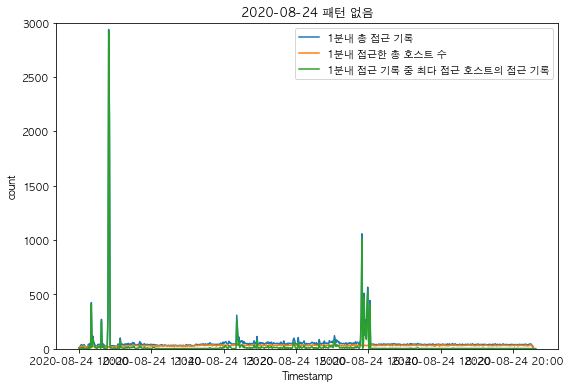

In [11]:
labels = ['1분내 총 접근 기록', '1분내 접근한 총 호스트 수', '1분내 접근 기록 중 최다 접근 호스트의 접근 기록']
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-24 패턴 없음')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

## 25일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임

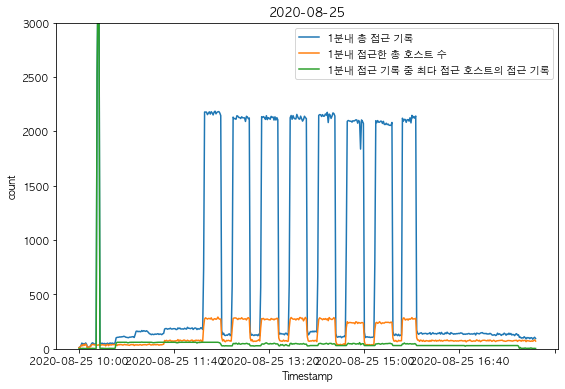

In [12]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-25')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

## 26일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임

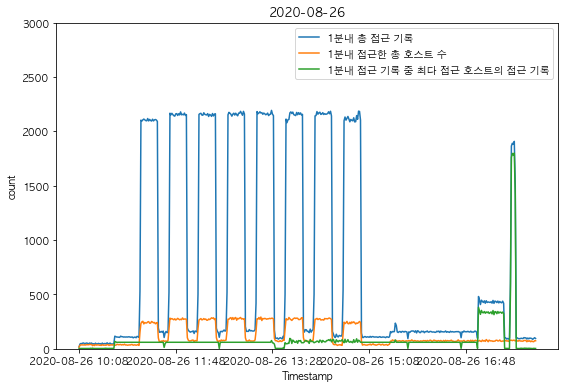

In [13]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-26')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

## 27일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임 (26일과 패턴이 똑같다)

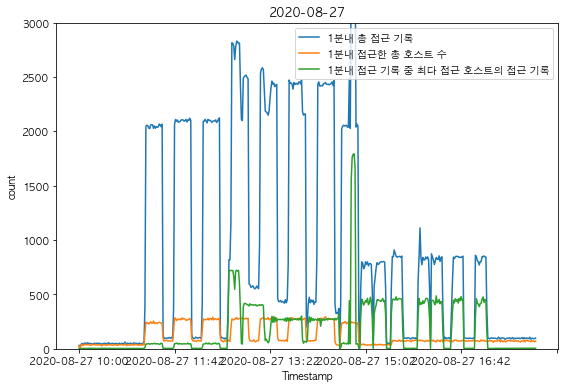

In [14]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-27')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

## 28일 총 6번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임 (비슷한 패턴을 보인다)

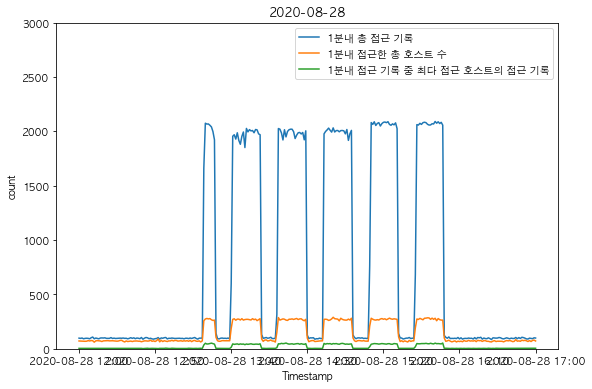

In [15]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-28')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

# 호스트가 단독으로 많이 들어오는 경우에는 시간에 따른 패턴이 없다.

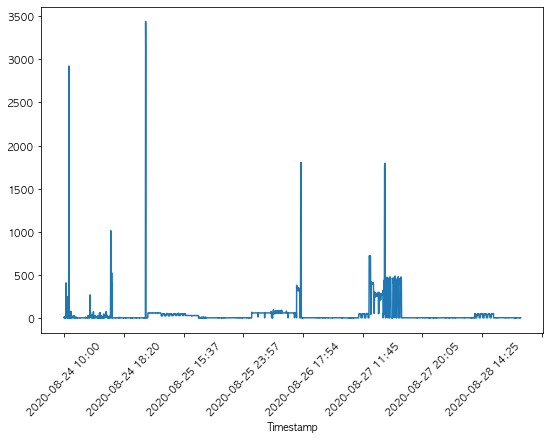

In [16]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['HostFirstValue'].sort_index().plot()
plt.xticks(rotation=45)
plt.show()

In [17]:
anoPattern = hostUniqueByMinute[hostUniqueByMinute['HostUnq'] > 200].index

In [18]:
# anoPattern = list(anomalyPattern)
anomalyPattern = anoPattern.tolist()
len(anomalyPattern)

532

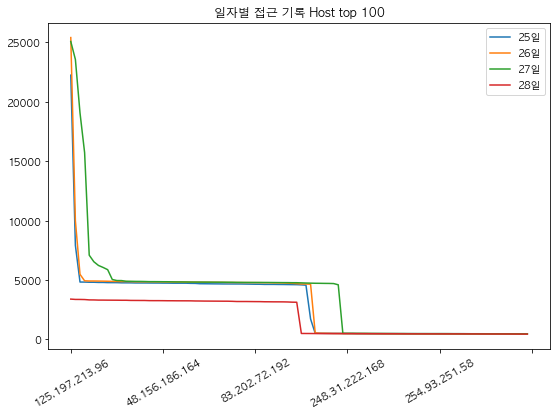

In [46]:
labels = ['25일','26일','27일','28일']
plt.figure(figsize=(9,6))
df['2020-08-25']['Host'].value_counts()[0:100].plot()
df['2020-08-26']['Host'].value_counts()[0:100].plot()
df['2020-08-27']['Host'].value_counts()[0:100].plot()
df['2020-08-28']['Host'].value_counts()[0:100].plot()
plt.title('일자별 접근 기록 Host top 100')
plt.xticks(rotation=30)
plt.legend(labels)
plt.show()

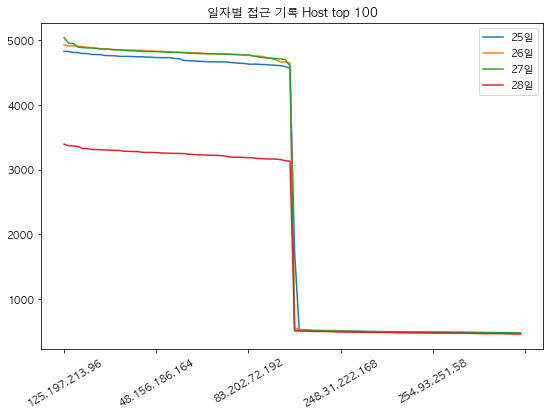

In [45]:
labels = ['25일','26일','27일','28일']
plt.figure(figsize=(9,6))
df['2020-08-25']['Host'].value_counts()[2:102].plot()
df['2020-08-26']['Host'].value_counts()[3:103].plot()
df['2020-08-27']['Host'].value_counts()[9:109].plot()
df['2020-08-28']['Host'].value_counts()[0:100].plot()
plt.title('일자별 접근 기록 Host top 100')
plt.xticks(rotation=30)
plt.legend(labels)
plt.show()

In [13]:
df = df.set_index(df['Timestamp'])
df.index = pd.to_datetime(df.index)

In [19]:
anoHost25 = df['2020-08-25']['Host'].value_counts()[2:52].index
anoHost25

Index(['189.102.137.171', '166.146.28.109', '93.139.7.167', '215.82.66.58',
       '62.126.184.49', '154.183.104.68', '192.217.106.4', '33.45.176.173',
       '209.163.210.98', '158.7.116.147', '157.29.174.233', '218.186.207.158',
       '155.110.66.204', '113.163.220.14', '96.220.20.38', '56.215.113.246',
       '253.72.61.176', '174.212.113.195', '181.208.169.183',
       '231.162.115.137', '128.60.55.30', '99.199.46.146', '230.91.143.108',
       '206.52.153.133', '41.235.176.98', '110.39.9.172', '194.48.94.171',
       '49.2.124.41', '13.112.117.158', '231.229.17.216', '180.113.58.104',
       '53.70.235.161', '9.27.108.183', '108.59.199.146', '58.33.250.234',
       '144.218.200.213', '77.51.208.6', '119.165.69.87', '223.7.119.122',
       '36.206.166.96', '207.44.179.175', '193.102.46.159', '118.194.121.61',
       '185.204.235.94', '87.232.221.120', '251.215.60.237', '122.236.50.249',
       '42.154.105.206', '249.221.133.56', '31.241.156.71'],
      dtype='object')

기밀성 침해 공격 분석을 통해 밝혀진 호스트를 제외하면 접근 기록 상위 50개의 호스트가 같은 비슷한 패턴으로 접근한다는 사실을 알수 있다.

In [20]:
anoHost26 = df['2020-08-26']['Host'].value_counts()[3:53].index
anoHost26

Index(['15.120.133.168', '68.246.216.126', '241.22.8.121', '236.162.53.8',
       '122.75.246.242', '210.159.169.113', '34.69.121.11', '149.231.211.148',
       '114.240.227.197', '75.98.230.167', '38.140.103.156', '111.120.134.184',
       '248.245.36.197', '140.22.209.246', '176.120.230.123', '73.25.144.98',
       '218.59.66.15', '244.192.204.214', '138.189.245.218', '22.160.80.50',
       '228.50.148.130', '45.43.242.153', '231.233.83.222', '247.83.158.223',
       '164.138.189.108', '38.219.8.203', '59.223.59.238', '5.157.107.195',
       '68.70.177.148', '52.235.119.115', '139.182.73.5', '177.208.153.113',
       '155.47.151.70', '25.232.211.103', '63.237.133.245', '37.64.245.73',
       '32.149.239.191', '89.118.222.166', '57.198.254.244', '184.13.27.188',
       '69.7.97.191', '88.125.247.149', '83.183.235.143', '84.229.129.163',
       '160.137.37.1', '198.208.191.234', '237.20.113.120', '144.74.30.34',
       '226.93.172.27', '85.176.102.221'],
      dtype='object')

In [21]:
anoHost27 = df['2020-08-27']['Host'].value_counts()[9:59].index
anoHost27

Index(['99.64.144.149', '129.197.168.17', '108.200.175.182', '179.109.202.163',
       '85.180.217.131', '167.145.154.40', '118.52.128.24', '223.55.122.183',
       '3.168.105.10', '134.253.9.38', '120.207.123.148', '248.208.120.149',
       '134.149.35.190', '64.50.31.61', '175.214.223.16', '235.160.25.129',
       '84.83.171.161', '9.112.183.31', '55.198.38.0', '31.62.244.218',
       '201.116.192.99', '232.143.134.156', '219.126.10.96', '62.66.235.25',
       '42.88.127.114', '238.60.95.5', '34.121.125.108', '219.240.45.95',
       '42.101.37.130', '242.162.51.166', '115.130.124.88', '41.121.130.0',
       '6.210.151.21', '155.101.146.48', '73.52.126.133', '145.104.81.213',
       '30.11.55.212', '129.236.75.8', '132.134.0.43', '203.165.187.206',
       '36.227.196.135', '35.146.170.79', '223.199.240.6', '183.209.224.212',
       '81.226.230.91', '55.185.6.120', '137.3.55.226', '123.252.177.154',
       '178.245.100.17', '219.229.163.141'],
      dtype='object')

In [22]:
anoHost28 = df['2020-08-28']['Host'].value_counts()[0:50].index
anoHost28

Index(['125.197.213.96', '73.159.164.232', '12.118.38.74', '39.112.75.139',
       '77.28.42.72', '10.161.50.95', '187.82.32.231', '187.19.60.109',
       '0.242.182.71', '236.117.113.88', '198.215.148.228', '106.254.46.141',
       '57.40.245.32', '109.126.152.174', '96.55.243.39', '147.245.128.177',
       '79.219.245.90', '236.79.11.24', '120.59.68.21', '97.157.219.191',
       '48.156.186.164', '115.112.105.145', '34.110.106.4', '100.227.232.242',
       '169.161.230.151', '34.235.217.86', '238.39.228.156', '212.254.82.60',
       '113.138.175.149', '124.236.155.199', '189.59.12.228', '219.40.100.241',
       '179.233.243.212', '120.126.24.186', '152.188.88.120', '85.49.64.128',
       '66.112.27.100', '155.2.137.36', '130.99.247.192', '241.166.70.82',
       '83.202.72.192', '141.127.187.88', '86.75.151.184', '77.13.148.197',
       '244.216.242.67', '205.254.127.151', '127.202.178.51', '89.133.124.168',
       '53.119.161.113', '240.174.206.196'],
      dtype='object')

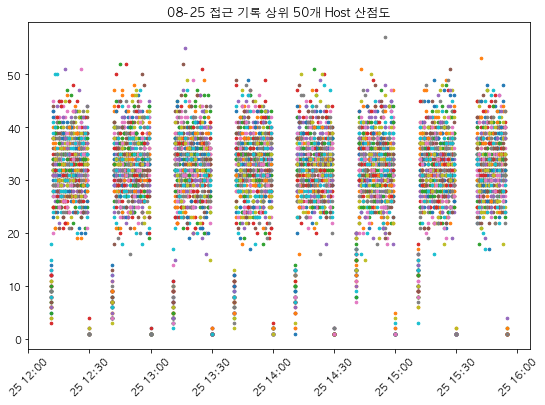

In [47]:
plt.figure(figsize=(9,6))
for i in range(50):
    x = df[df['Host'] == anoHost25[i]].index.value_counts().sort_index().index
    y = df[df['Host'] == anoHost25[i]].index.value_counts().sort_index()
    plt.scatter(x, y, s=7)
plt.xticks(rotation=45)
plt.title('08-25 접근 기록 상위 50개 Host 산점도')
plt.show()


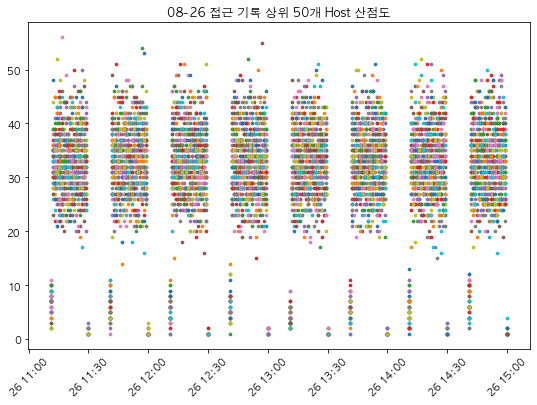

In [48]:
plt.figure(figsize=(9,6))
for i in range(50):
    x = df[df['Host'] == anoHost26[i]].index.value_counts().sort_index().index
    y = df[df['Host'] == anoHost26[i]].index.value_counts().sort_index()
    plt.scatter(x, y, s=7)
plt.xticks(rotation=45)
plt.title('08-26 접근 기록 상위 50개 Host 산점도')
plt.show()


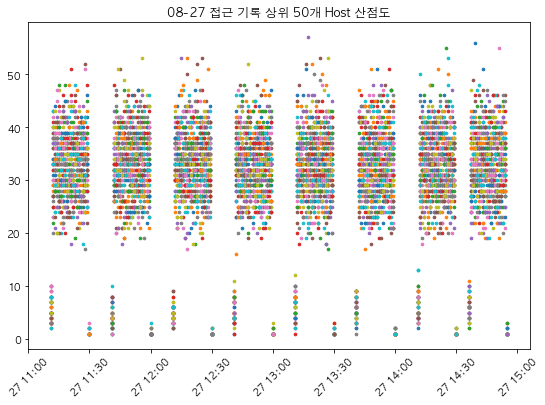

In [49]:
plt.figure(figsize=(9,6))
for i in range(50):
    x = df[df['Host'] == anoHost27[i]].index.value_counts().sort_index().index
    y = df[df['Host'] == anoHost27[i]].index.value_counts().sort_index()
    plt.scatter(x, y, s=7)
plt.xticks(rotation=45)
plt.title('08-27 접근 기록 상위 50개 Host 산점도')
plt.show()


In [ ]:
plt.figure(figsize=(9,6))
for i in range(50):
    x = df[df['Host'] == anoHost27[i]].index.value_counts().sort_index().index
    y = df[df['Host'] == anoHost27[i]].index.value_counts().sort_index()
    plt.scatter(x, y, s=7)
plt.xticks(rotation=45)
plt.title('08-27 접근 기록 상위 50개 Host 산점도')
plt.show()


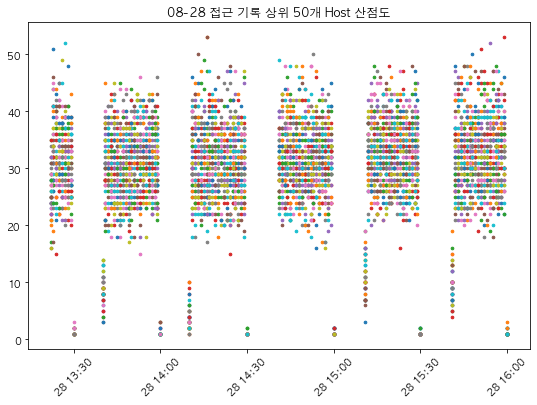

In [50]:
plt.figure(figsize=(9,6))
for i in range(50):
    x = df[df['Host'] == anoHost28[i]].index.value_counts().sort_index().index
    y = df[df['Host'] == anoHost28[i]].index.value_counts().sort_index()
    plt.scatter(x, y, s=7)
plt.xticks(rotation=45)
plt.title('08-28 접근 기록 상위 50개 Host 산점도')
plt.show()


In [23]:
anoHost25List = anoHost25.tolist()
anoHost26List = anoHost26.tolist()
anoHost27List = anoHost27.tolist()
anoHost28List = anoHost28.tolist()
anoHostList = anoHost25List + anoHost26List + anoHost27List + anoHost28List
anoHostList

['189.102.137.171',
 '166.146.28.109',
 '93.139.7.167',
 '215.82.66.58',
 '62.126.184.49',
 '154.183.104.68',
 '192.217.106.4',
 '33.45.176.173',
 '209.163.210.98',
 '158.7.116.147',
 '157.29.174.233',
 '218.186.207.158',
 '155.110.66.204',
 '113.163.220.14',
 '96.220.20.38',
 '56.215.113.246',
 '253.72.61.176',
 '174.212.113.195',
 '181.208.169.183',
 '231.162.115.137',
 '128.60.55.30',
 '99.199.46.146',
 '230.91.143.108',
 '206.52.153.133',
 '41.235.176.98',
 '110.39.9.172',
 '194.48.94.171',
 '49.2.124.41',
 '13.112.117.158',
 '231.229.17.216',
 '180.113.58.104',
 '53.70.235.161',
 '9.27.108.183',
 '108.59.199.146',
 '58.33.250.234',
 '144.218.200.213',
 '77.51.208.6',
 '119.165.69.87',
 '223.7.119.122',
 '36.206.166.96',
 '207.44.179.175',
 '193.102.46.159',
 '118.194.121.61',
 '185.204.235.94',
 '87.232.221.120',
 '251.215.60.237',
 '122.236.50.249',
 '42.154.105.206',
 '249.221.133.56',
 '31.241.156.71',
 '15.120.133.168',
 '68.246.216.126',
 '241.22.8.121',
 '236.162.53.8',
 '12

In [24]:
anoHostList2 = ['101.224.32.28', '231.211.11.16', '137.8.46.133', '100.200.156.222', '112.112.181.134', '188.45.31.10', '188.45.31.20', '188.45.31.30', '188.45.31.40', '14.135.56.110', '14.135.56.120', '14.135.56.130', '14.135.56.140']

In [25]:
anoHostStr = '|'.join(anoHostList)
anoHostStr2 = '|'.join(anoHostList2)
normalHostListReverse = anoHostList + anoHostList2
normalHostStrReverse = '|'.join(normalHostListReverse)

In [27]:
patterIps = df[df['Host'].str.contains(anoHostStr, na=False)]

In [30]:
del(patterIps['Timestamp'])

In [34]:
patterIps.to_csv('patternIps.csv', mode='w')

In [69]:
a = len(df[df['Host'].str.contains(anoHostStr, na=False)])
b = len(df[df['Host'].str.contains(anoHostStr2, na=False)])

print(a)
print(b)


879089
201959


In [71]:
c = len(df[~df['Host'].str.contains(normalHostStrReverse, na=False)])
print(c)

455960


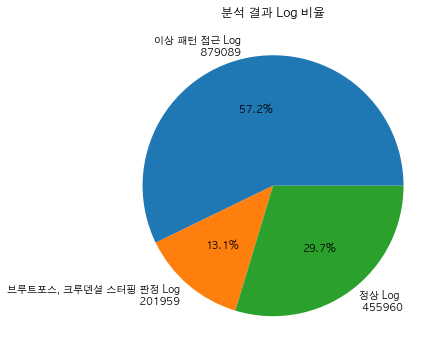

In [97]:
ratio = [879089, 201959, 455960]
labels = [f'이상 패턴 접근 Log\n {ratio[0]}', 
          f'브루트포스, 크루덴셜 스터핑 판정 Log\n {ratio[1]}',
          f'정상 Log\n {ratio[2]}']
plt.figure(figsize=(9,6))
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.title('분석 결과 Log 비율')
plt.show()

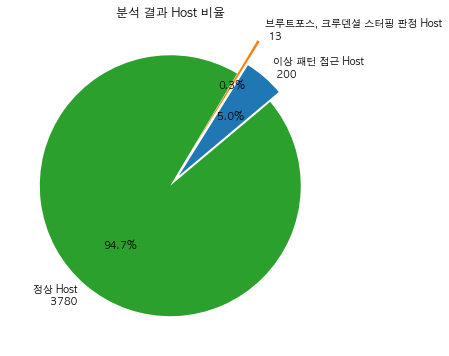

In [98]:
ratio = [200, 13, 3780]
labels = [f'이상 패턴 접근 Host\n {ratio[0]}', 
          f'브루트포스, 크루덴셜 스터핑 판정 Host\n {ratio[1]}',
          f'정상 Host\n {ratio[2]}']
plt.figure(figsize=(9,6))
plt.pie(ratio, labels=labels, startangle=40, explode=(0.1,0.3,0), autopct='%.1f%%')
plt.title('분석 결과 Host 비율')
plt.show()

In [101]:
df[df['Host'].str.contains(anoHostStr, na=False)]['Referer'].value_counts()[:30]

"http://wp.hotpost.kr/"                              691100
"                                                     24591
"http://xe.coldshop.kr/shop?mid=shop&page=5"          13479
"http://xe.coldshop.kr/shop?mid=shop&page=4"          13451
"http://xe.coldshop.kr/shop?mid=shop&page=6"          13435
"http://xe.coldshop.kr/shop?mid=shop&page=3"          13418
"http://xe.coldshop.kr/shop?mid=shop&page=7"          13409
"http://xe.coldshop.kr/shop?mid=shop&page=9"          13403
"http://xe.coldshop.kr/shop?mid=shop&page=8"          13349
"http://xe.coldshop.kr/shop?mid=shop&page=10"         13279
"http://xe.coldshop.kr/shop?mid=shop&page=2"          13268
"http://xe.coldshop.kr/shop?mid=shop&page=1"          13222
"http://xe.coldshop.kr/notice?mid=notice&page=7"       1260
"http://xe.coldshop.kr/notice?mid=notice&page=2"       1257
"http://xe.coldshop.kr/notice?mid=notice&page=6"       1257
"http://xe.coldshop.kr/events?mid=events&page=8"       1245
"http://xe.coldshop.kr/notice?mid=notice

In [125]:
webScrap = df[df['Referer'] == '"']['Host'].value_counts()[:50].index
webScrap = webScrap.tolist()
webScrap = '|'.join(webScrap)
webScrap

'129.197.168.17|137.3.55.226|85.180.217.131|134.253.9.38|31.62.244.218|183.209.224.212|134.149.35.190|62.66.235.25|115.130.124.88|235.160.25.129|30.11.55.212|64.50.31.61|219.126.10.96|108.200.175.182|73.52.126.133|201.116.192.99|34.121.125.108|219.229.163.141|3.168.105.10|175.214.223.16|9.112.183.31|179.109.202.163|242.162.51.166|203.165.187.206|178.245.100.17|84.83.171.161|167.145.154.40|145.104.81.213|6.210.151.21|42.101.37.130|223.55.122.183|99.64.144.149|118.52.128.24|132.134.0.43|223.199.240.6|36.227.196.135|238.60.95.5|41.121.130.0|248.208.120.149|155.101.146.48|120.207.123.148|55.198.38.0|219.240.45.95|35.146.170.79|232.143.134.156|129.236.75.8|42.88.127.114|55.185.6.120|81.226.230.91|123.252.177.154'

In [160]:
webScrapDf = df[df['Host'].str.contains(webScrap, na=False)]
webScrapDfReverse = df[~df['Host'].str.contains(webScrap, na=False)]

In [161]:
print(webScrapDf["Bytes"].mean())
print(webScrapDfReverse["Bytes"].mean())

22053.291997972698
18376.504726196945


In [59]:
df[df['Host'].str.contains(anoHost28Str, na=False)]

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
Timestamp,,,,,,,,,
2020-08-28 13:22:00,GET,HTTP/1.1,200,"""http://wp.hotpost.kr/""",/?p=1470,189.59.12.228,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,-,23520.0
2020-08-28 13:22:00,GET,HTTP/1.1,200,"""http://wp.hotpost.kr/""",/?p=4373,244.216.242.67,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,-,24285.0
2020-08-28 13:22:00,GET,HTTP/1.1,200,"""http://wp.hotpost.kr/""",/?p=3883,48.156.186.164,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3)...,-,38777.0
2020-08-28 13:22:00,GET,HTTP/1.1,200,"""http://wp.hotpost.kr/""",/?p=4369,53.119.161.113,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,-,24123.0
2020-08-28 13:22:00,GET,HTTP/1.1,200,"""http://wp.hotpost.kr/""",/?p=506,0.242.182.71,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2)...,-,23375.0
...,...,...,...,...,...,...,...,...,...
2020-08-28 16:00:00,GET,HTTP/1.1,200,"""http://wp.hotpost.kr/""",/?p=6749,77.28.42.72,Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.3...,-,24057.0
2020-08-28 16:00:00,GET,HTTP/1.1,200,"""http://wp.hotpost.kr/""",/?p=5765,12.118.38.74,Mozilla/5.0 (X11; Ubuntu; Linux i686 on x86_64...,-,24207.0
2020-08-28 16:00:00,GET,HTTP/1.1,200,"""http://wp.hotpost.kr/""",/?p=462,147.245.128.177,Mozilla/5.0 (Windows NT 6.4; WOW64) AppleWebKi...,-,23369.0


In [75]:
df['Host'].value_counts()

101.224.32.28      27757
112.112.181.134    25404
188.45.31.30       25071
188.45.31.20       23562
231.211.11.16      22238
                   ...  
144.122.58.178         1
166.1.216.110          1
190.78.83.95           1
170.54.6.180           1
183.143.153.71         1
Name: Host, Length: 3993, dtype: int64

In [ ]:
'189.102.137.171',
'166.146.28.109',
'215.82.66.58',
'93.139.7.167',
'62.126.184.49',
'154.183.104.68',
'192.217.106.4',
'33.45.176.173',
'209.163.210.98',
'158.7.116.147',
'157.29.174.233',
'218.186.207.158',
'155.110.66.204',
'96.220.20.38',
'113.163.220.14',
'56.215.113.246',
'253.72.61.176',
 '174.212.113.195',
 '181.208.169.183',
 '231.162.115.137',
 '128.60.55.30',
 '99.199.46.146',
 '206.52.153.133',
 '230.91.143.108',
 '41.235.176.98',
 '110.39.9.172',
 '194.48.94.171',
 '49.2.124.41',
 '13.112.117.158',
 '231.229.17.216',
 '180.113.58.104',
 '53.70.235.161',
 '9.27.108.183',
 '108.59.199.146',
 '58.33.250.234',
 '144.218.200.213',
 '77.51.208.6',
 '119.165.69.87',
 '223.7.119.122',
 '36.206.166.96',
 '118.194.121.61',
 '207.44.179.175',
 '193.102.46.159',
 '185.204.235.94',
 '87.232.221.120',
 '251.215.60.237',
 '122.236.50.249',
 '42.154.105.206',
 '249.221.133.56',
 '31.241.156.71',
 '15.120.133.168',
 '68.246.216.126',
 '241.22.8.121',
 '236.162.53.8',
 '122.75.246.242',
 '210.159.169.113',
 '34.69.121.11',
 '149.231.211.148',
 '75.98.230.167',
 '114.240.227.197',
 '38.140.103.156',
 '111.120.134.184',
 '248.245.36.197',
 '140.22.209.246',
 '176.120.230.123',
 '73.25.144.98',
 '218.59.66.15',
 '244.192.204.214',
 '22.160.80.50',
 '138.189.245.218',
 '45.43.242.153',
 '228.50.148.130',
 '231.233.83.222',
 '247.83.158.223',
 '164.138.189.108',
 '38.219.8.203',
 '59.223.59.238',
 '5.157.107.195',
 '52.235.119.115',
 '68.70.177.148',
 '139.182.73.5',
 '155.47.151.70',
 '177.208.153.113',
 '25.232.211.103',
 '63.237.133.245',
 '32.149.239.191',
 '37.64.245.73',
 '89.118.222.166',
 '57.198.254.244',
 '184.13.27.188',
 '69.7.97.191',
 '88.125.247.149',
 '83.183.235.143',
 '84.229.129.163',
 '160.137.37.1',
 '198.208.191.234',
 '237.20.113.120',
 '144.74.30.34',
 '226.93.172.27',
 '85.176.102.221',
 '99.64.144.149',
 '129.197.168.17',
 '108.200.175.182',
 '179.109.202.163',
 '85.180.217.131',
 '167.145.154.40',
 '118.52.128.24',
 '223.55.122.183',
 '134.253.9.38',
 '3.168.105.10',
 '120.207.123.148',
 '248.208.120.149',
 '134.149.35.190',
 '64.50.31.61',
 '175.214.223.16',
 '235.160.25.129',
 '84.83.171.161',
 '9.112.183.31',
 '55.198.38.0',
 '31.62.244.218',
 '201.116.192.99',
 '232.143.134.156',
 '219.126.10.96',
 '62.66.235.25',
 '42.88.127.114',
 '238.60.95.5',
 '34.121.125.108',
 '219.240.45.95',
 '42.101.37.130',
 '242.162.51.166',
 '115.130.124.88',
 '6.210.151.21',
 '41.121.130.0',
 '155.101.146.48',
 '73.52.126.133',
 '145.104.81.213',
 '30.11.55.212',
 '129.236.75.8',
 '132.134.0.43',
 '203.165.187.206',
 '36.227.196.135',
 '35.146.170.79',
 '223.199.240.6',
 '183.209.224.212',
 '81.226.230.91',
 '55.185.6.120',
 '137.3.55.226',
 '123.252.177.154',
 '178.245.100.17',
 '219.229.163.141',
 '125.197.213.96',
 '73.159.164.232',
 '12.118.38.74',
 '39.112.75.139',
 '77.28.42.72',
 '10.161.50.95',
 '187.82.32.231',
 '187.19.60.109',
 '0.242.182.71',
 '236.117.113.88',
 '198.215.148.228',
 '57.40.245.32',
 '106.254.46.141',
 '109.126.152.174',
 '96.55.243.39',
 '147.245.128.177',
 '79.219.245.90',
 '236.79.11.24',
 '97.157.219.191',
 '120.59.68.21',
 '48.156.186.164',
 '115.112.105.145',
 '34.110.106.4',
 '100.227.232.242',
 '169.161.230.151',
 '34.235.217.86',
 '238.39.228.156',
 '212.254.82.60',
 '113.138.175.149',
 '124.236.155.199',
 '189.59.12.228',
 '219.40.100.241',
 '179.233.243.212',
 '120.126.24.186',
 '152.188.88.120',
 '85.49.64.128',
 '66.112.27.100',
 '155.2.137.36',
 '130.99.247.192',
 '241.166.70.82',
 '83.202.72.192',
 '141.127.187.88',
 '86.75.151.184',
 '77.13.148.197',
 '244.216.242.67',
 '205.254.127.151',
 '127.202.178.51',
 '89.133.124.168',
 '53.119.161.113',
 '240.174.206.196'